In [38]:
import pandas as pd
import numpy as np
from loaders import load_data
import datetime

TEST_SIZE = 50
TRAIN_SIZE = 1999 + 50

load_GEF = load_data(path_name='data/load_data_track1.csv', test_size=TEST_SIZE, random_state=0)
load_df = pd.read_csv('data/load_data_track1.csv')

load_df.rename( columns={'Unnamed: 0' :'TIMESTAMP'}, inplace=True )
load_df.rename( columns={'LOAD' :'TARGETVAR'}, inplace=True )

load_df['OLD_TIMESTAMP'] =  pd.to_datetime(load_df['TIMESTAMP'], format='%Y-%m-%d %H:%M:%S.%f')
load_df['TIMESTAMP'] =  pd.DatetimeIndex(load_df['OLD_TIMESTAMP']) + pd.offsets.Hour(-1)
load_df['hour'] = pd.DatetimeIndex(load_df['TIMESTAMP']).hour.values
load_df['month'] = pd.DatetimeIndex(load_df['TIMESTAMP']).month.values
load_df['new_date'] = [d.date() for d in load_df['TIMESTAMP']]


#LS 1999 days #VS 50 days # TEST 50 days


In [39]:
load_df['TARGETVAR'] = load_df['TARGETVAR']/load_df['TARGETVAR'].max()
load_df['avg_hour_load'] = 0
for ind, hload in enumerate(load_GEF[1].mean(axis = 0)):
    load_df.loc[load_df['hour'] == ind, 'avg_hour_load'] = hload
load_df

,TIMESTAMP,TARGETVAR,w1,w2,w3,w4,w5,w6,w7,w8,...,w21,w22,w23,w24,w25,OLD_TIMESTAMP,hour,month,new_date,avg_hour_load
0,2005-01-01 00:00:00,0.398606,43,46,40,47,48,46,44,52,...,47,41,47,47,45,2005-01-01 01:00:00,0,1,2005-01-01,0.391398
1,2005-01-01 01:00:00,0.385932,41,46,38,46,48,45,51,50,...,47,45,47,47,45,2005-01-01 02:00:00,1,1,2005-01-01,0.372993
2,2005-01-01 02:00:00,0.370722,40,46,37,45,45,45,49,48,...,46,45,46,46,43,2005-01-01 03:00:00,2,1,2005-01-01,0.364120
3,2005-01-01 03:00:00,0.362484,39,46,37,47,48,48,45,50,...,44,45,47,47,44,2005-01-01 04:00:00,3,1,2005-01-01,0.362065
4,2005-01-01 04:00:00,0.359949,38,46,37,44,48,49,43,50,...,45,45,47,46,44,2005-01-01 05:00:00,4,1,2005-01-01,0.369193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50371,2010-09-30 19:00:00,0.560203,75,70,61,73,72,79,70,71,...,77,70,71,71,71,2010-09-30 20:00:00,19,9,2010-09-30,0.544929
50372,2010-09-30 20:00:00,0.536755,75,70,61,72,72,79,69,70,...,77,70,72,70,70,2010-09-30 21:00:00,20,9,2010-09-30,0.541966
50373,2010-09-30 21:00:00,0.493663,74,70,61,71,71,70,70,70,...,72,70,71,70,70,2010-09-30 22:00:00,21,9,2010-09-30,0.521348
50374,2010-09-30 22:00:00,0.455640,73,70,61,69,71,70,70,70,...,69,68,72,72,70,2010-09-30 23:00:00,22,9,2010-09-30,0.476891


In [40]:
import datetime

test_dates = []
for d in load_GEF[5].index:
    test_dates.append(d.date())

train_dates = []
for d in load_GEF[1].index:
    train_dates.append(d.date())
for d in load_GEF[3].index:
    train_dates.append(d.date())

features = ['w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7',
       'w8', 'w9', 'w10', 'w11', 'w12', 'w13', 'w14', 'w15', 'w16', 'w17',
       'w18', 'w19', 'w20', 'w21', 'w22', 'w23', 'w24', 'w25', 'hour', 'month', 'avg_hour_load']
test_dates = pd.Series(test_dates)
train_dates = pd.Series(train_dates)
train = load_df[~load_df['new_date'].isin(test_dates.unique())].copy()
test = load_df[load_df['new_date'].isin(test_dates.unique())].copy()
x_train = train[features]
x_test = test[features]
y_train = train['TARGETVAR']
y_test = test['TARGETVAR']

In [41]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_pinball_loss, mean_squared_error

num_quantiles = 100
quantiles = np.arange(0, 1, 1/num_quantiles)[1:]

common_params = dict(
    learning_rate=0.05,
    n_estimators=600,
    max_depth=7,
    min_samples_leaf=9,
    min_samples_split=9,
)

predictions = []
train_predictions = []
for alpha in quantiles:
    gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, **common_params)
    model = gbr.fit(x_train, y_train)
    y_pred = gbr.predict(x_test)

    x_pred = gbr.predict(x_train)
    predictions.append(y_pred)
    train_predictions.append(x_pred)
predictions = np.array(predictions)
train_predictions = np.array(train_predictions)

In [42]:
sorted_predictions = np.sort(predictions, axis=0)
sorted_train_predictions = np.sort(train_predictions, axis=0)

results = []
for i, q in enumerate(quantiles):
    results.append(mean_pinball_loss(y_test, sorted_predictions[i], alpha=q))

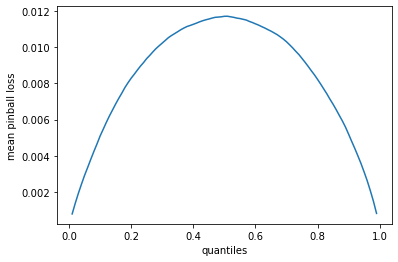

In [43]:
import matplotlib.pyplot as plt

plt.plot(quantiles, results)
plt.ylabel('mean pinball loss')
plt.xlabel('quantiles')
plt.show()

Quantile sqore: 0.8362275047065664


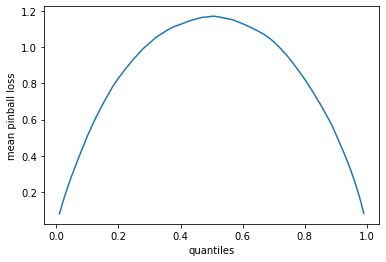

In [44]:
import metrics

plf = metrics.plf_per_quantile(sorted_predictions/load_df.TARGETVAR.max(), y_test/load_df.TARGETVAR.max())
print("Quantile sqore:", plf.mean())
plt.plot(quantiles, plf)
plt.ylabel('mean pinball loss')
plt.xlabel('quantiles')
plt.show()

In [45]:
y_copy = pd.DataFrame(y_test.copy())
y_copy['pos'] = np.arange(y_test.shape[0])
y_copy['old_pos'] = y_copy.index
y_copy

,TARGETVAR,pos,old_pos
1152,0.449937,0,1152
1153,0.456591,1,1153
1154,0.470215,2,1154
1155,0.485108,3,1155
1156,0.511407,4,1156
...,...,...,...
48907,0.555450,1195,48907
48908,0.555767,1196,48908
48909,0.553232,1197,48909
48910,0.514259,1198,48910


In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import copula
N_SCENARIOS = 100

y_train_copy = pd.DataFrame(y_train.copy())
y_train_copy['pos'] = np.arange(y_train.shape[0])
y_train_copy['old_pos'] = y_train_copy.index

idx = np.arange(TRAIN_SIZE)
np.random.shuffle(idx)

cov_matrix = np.identity(24)

for i in idx:
    pred = pd.DataFrame(sorted_train_predictions[:,y_train_copy[y_train_copy['old_pos'].isin(load_df[load_df['new_date'] == train_dates.unique()[i]].index)]['pos']].T)
    actual_data = y_train_copy[y_train_copy['old_pos'].isin(load_df[load_df['new_date'] == train_dates.unique()[i]].index)]['TARGETVAR']
    cov_matrix = copula.update_cov_matrix(df_y_pred_q=pred, quantiles=quantiles, 
                      actual_data=actual_data, forget_factor=0.99, cov_matrix=cov_matrix)

y_to_pass = []
scenarios_pred = []


for i in range(TEST_SIZE):
    pred = pd.DataFrame(sorted_predictions[:,y_copy[y_copy['old_pos'].isin(load_df[load_df['new_date'] == test_dates.unique()[i]].index)]['pos']].T)
    actual_data = y_copy[y_copy['old_pos'].isin(load_df[load_df['new_date'] == test_dates.unique()[i]].index)]['TARGETVAR']
    generated_scenarios = copula.sample_from_quantiles(df_y_pred_q=pred, quantiles=quantiles, cov_matrix=cov_matrix, n_scenarios=N_SCENARIOS, rnd_seed=[0], sort=True)
    scenarios_pred.append(generated_scenarios)
    y_to_pass.append(actual_data)

y_to_pass = np.array(y_to_pass)

scenarios_pred = np.array(scenarios_pred)
scenarios_pred = scenarios_pred.reshape(-1, N_SCENARIOS)

energy_scoring = metrics.energy_score(scenarios_pred/load_df.TARGETVAR.max(), y_to_pass/load_df.TARGETVAR.max())
print("Average energy score:", np.array(energy_scoring).mean() * 100)

Average energy score: 9.740504203926433


In [48]:
energy_scoring = metrics.energy_score(scenarios_pred/load_df.TARGETVAR.max(), y_to_pass/load_df.TARGETVAR.max())
print("Average normalized energy score:", np.array(energy_scoring).mean() * 100)

Average normalized energy score: 9.740504203926433


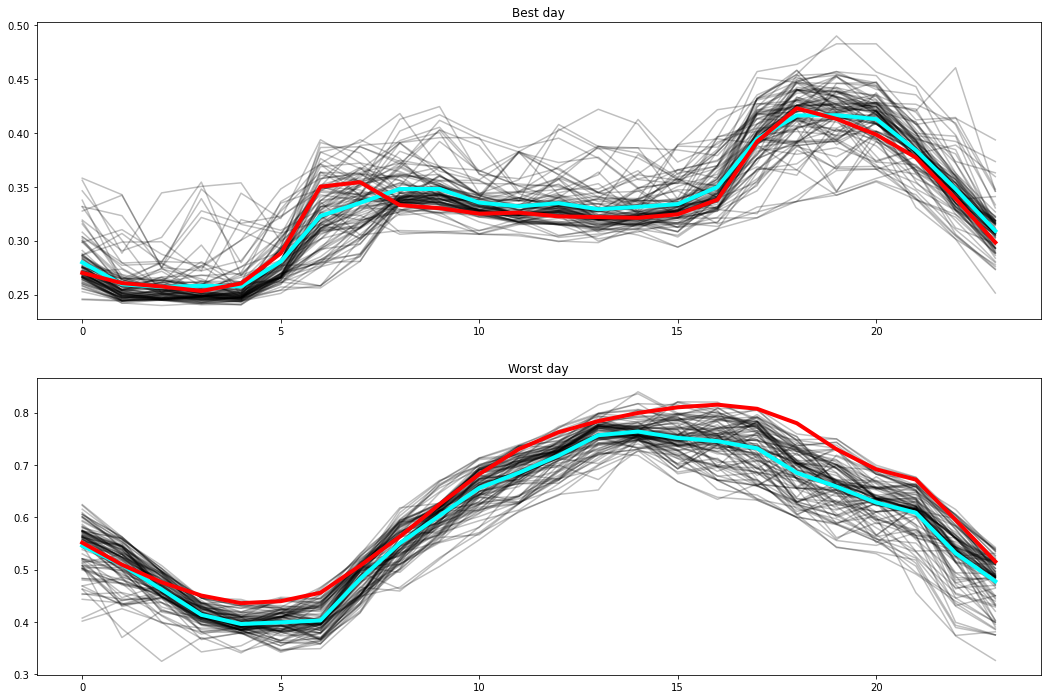

In [49]:
best_day = np.argmin(energy_scoring)
worst_day = np.argmax(energy_scoring)
fig = plt.figure(figsize=(18, 12))

columns = 1
rows = 2

ax = []
ax.append( fig.add_subplot(rows, columns, 1) )
ax[-1].set_title("Best day")
plt.plot(scenarios_pred[best_day*24:best_day*24+24], color='k', alpha=0.25)
plt.plot(scenarios_pred[best_day*24:best_day*24+24].mean(axis=1), color='cyan', label='Generated Scenarios Mean', linewidth=4)
plt.plot(np.arange(24), y_to_pass[best_day], color='red', linewidth=4)

ax.append( fig.add_subplot(rows, columns, 2) )
ax[-1].set_title("Worst day")
plt.plot(scenarios_pred[worst_day*24:worst_day*24+24], color='k', alpha=0.25)
plt.plot(scenarios_pred[worst_day*24:worst_day*24+24].mean(axis=1), color='cyan', label='Generated Scenarios Mean', linewidth=4)
plt.plot(np.arange(24), y_to_pass[worst_day], color='red', linewidth=4)
plt.show()

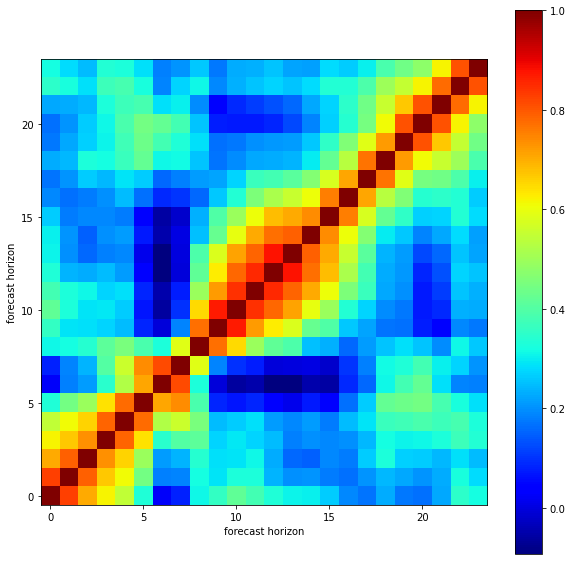

In [50]:
plt.figure(figsize=(10,10))
pos = plt.imshow(cov_matrix, cmap='jet', origin='lower')
plt.xlabel('forecast horizon')
plt.ylabel('forecast horizon')
plt.colorbar(pos)
plt.show()

In [51]:
x_train

,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,...,w19,w20,w21,w22,w23,w24,w25,hour,month,avg_hour_load
0,43,46,40,47,48,46,44,52,45,42,...,45,50,47,41,47,47,45,0,1,0.391398
1,41,46,38,46,48,45,51,50,42,41,...,46,47,47,45,47,47,45,1,1,0.372993
2,40,46,37,45,45,45,49,48,43,40,...,45,45,46,45,46,46,43,2,1,0.364120
3,39,46,37,47,48,48,45,50,42,39,...,43,45,44,45,47,47,44,3,1,0.362065
4,38,46,37,44,48,49,43,50,42,38,...,43,43,45,45,47,46,44,4,1,0.369193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50371,75,70,61,73,72,79,70,71,59,71,...,71,70,77,70,71,71,71,19,9,0.544929
50372,75,70,61,72,72,79,69,70,59,70,...,70,70,77,70,72,70,70,20,9,0.541966
50373,74,70,61,71,71,70,70,70,59,70,...,70,70,72,70,71,70,70,21,9,0.521348
50374,73,70,61,69,71,70,70,70,59,70,...,69,70,69,68,72,72,70,22,9,0.476891


In [ ]:
#1)add an average value as feature to dataset for the hour, as well as month of the year
#2)check feature importance for time features